# NBA Player Salaries (2022-23 Season)
## Projekt PAD
### Daniel Fekete

# Introduction

In the analysis, we used a dataset from:
    https://www.kaggle.com/datasets/jamiewelsh2/nba-player-salaries-2022-23-season/data
This dataset provides information about NBA players in the 2022 - 2023 season and we will use the following variables from it:

* Player Name
* Salary
* Position
* Age
* Team
* GP: Games Played
* GS: Number of matches in which the player started in the starting lineup
* PTS: Average points per game



First, let's import the important and necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy.stats import ttest_ind, levene
from scipy.stats import chi2_contingency

import seaborn as sns

Import dataset:

In [ ]:
df = pd.read_csv("nba_2022-23_all_stats_with_salary.csv")

Plotting a part of a dataframe:

In [31]:
df.head()

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


In [33]:
data_cleaned = df.drop(columns=['Unnamed: 0'])

## Exploratory Analysis - Overview
We will create basic visualizations

In [ ]:
age_bins = pd.cut(data_cleaned['Age'], bins=[18, 23, 28, 33, 38, 43], labels=['18-23', '24-28', '29-33', '34-38', '39-43'])
age_distribution = age_bins.value_counts().sort_index()

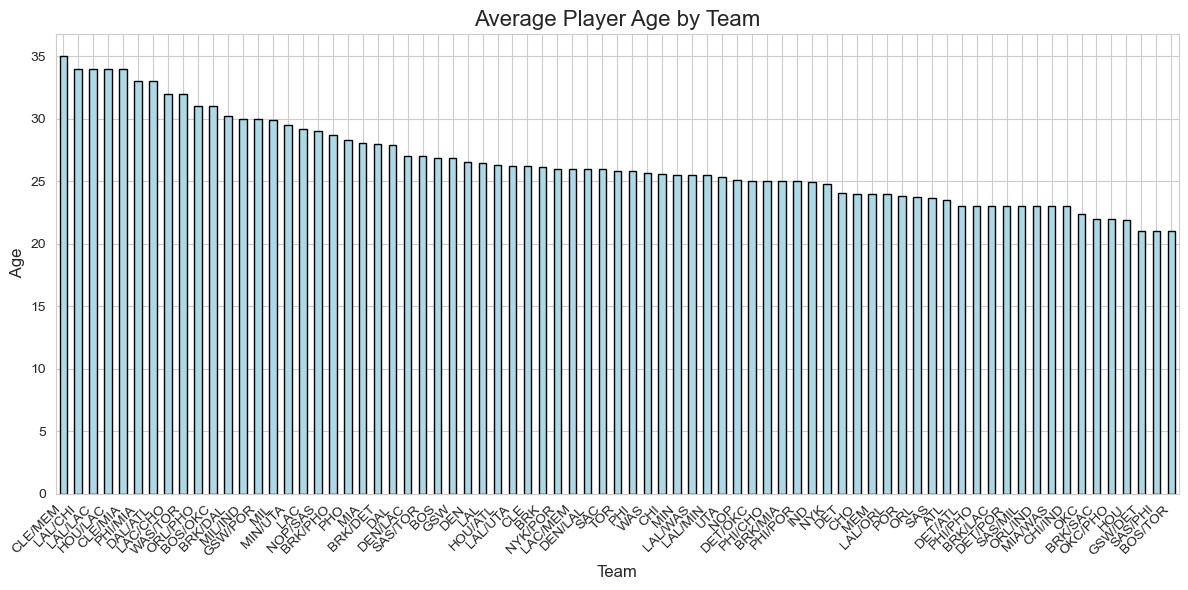

In [159]:
average_age_by_team = df.groupby('Team')['Age'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
average_age_by_team.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Average Player Age by Team', fontsize=16)
plt.ylabel(' Age', fontsize=12)
plt.xlabel('Team', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

Conclusion:

The graph showed the average age of the players in the teams. From the results, we can conclude that there are differences in the average age of the players between the individual teams.

<Axes: xlabel='Age', ylabel='count'>

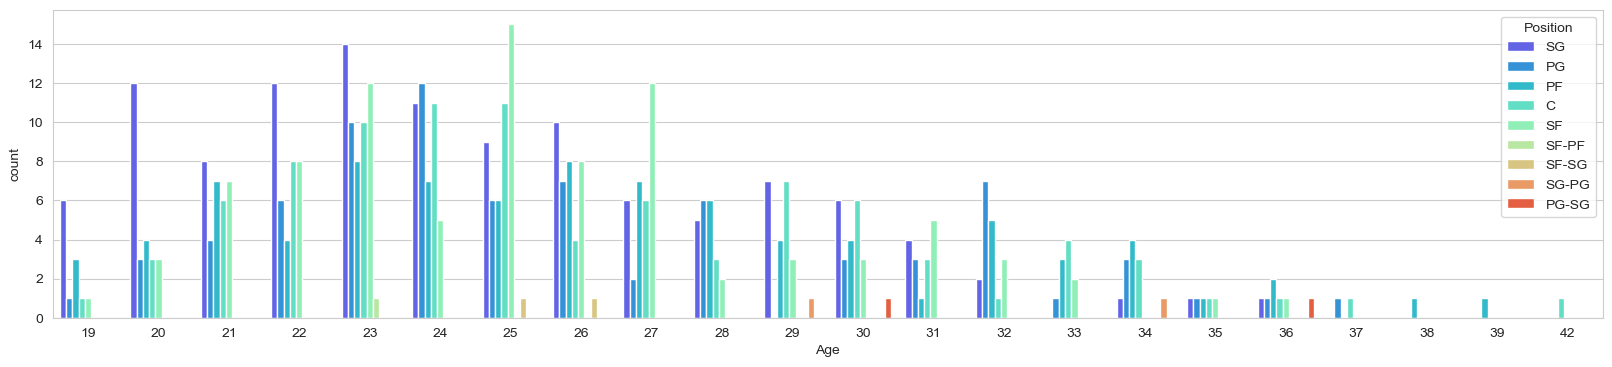

In [36]:
plt.figure(figsize=(20,4))
sns.set_style('whitegrid')
sns.countplot(x='Age',hue='Position', data=df,palette='rainbow')

Conclusion:

The age distribution of NBA players shows some symmetry, similar to a normal distribution. Most players fall into the age range between 22 and 27 years. There are no players older than 43 years old recorded in the dataset, which suggests an age limit for professional NBA players.

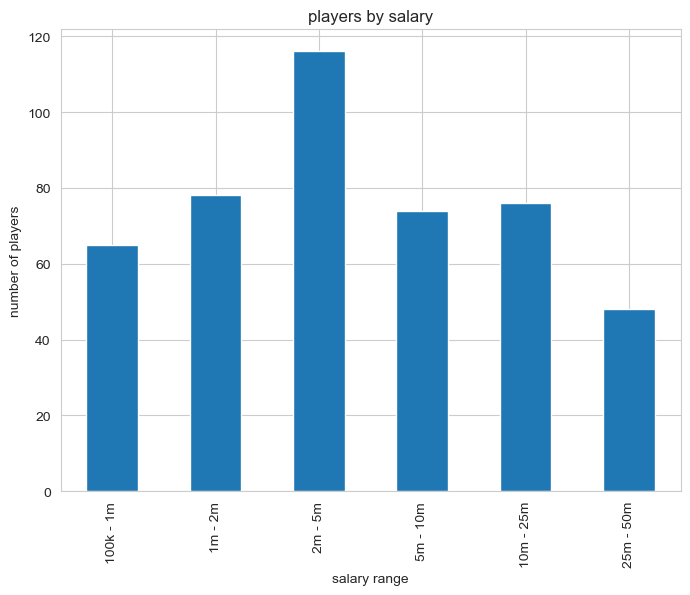

In [38]:
salary_bins = pd.cut(data_cleaned['Salary'], bins=[100000, 1000000,2000000, 5000000,10000000, 25000000, 50000000], labels=['100k - 1m', '1m - 2m','2m - 5m',  '5m - 10m', '10m - 25m', '25m - 50m'])
salary_distribution = salary_bins.value_counts().sort_index()
plt.figure(figsize=(8, 6))
salary_distribution.plot(kind='bar')
plt.title('players by salary')
plt.xlabel('salary range')
plt.ylabel('number of players')
plt.show()

Conclusion:

The graph shows that the majority of players have salaries in the $100k to $2m range, with the number of players gradually decreasing as they move up the salary scale. The fewest players earn between $25m and $50m, reflecting that only the elite players earn the highest salaries.

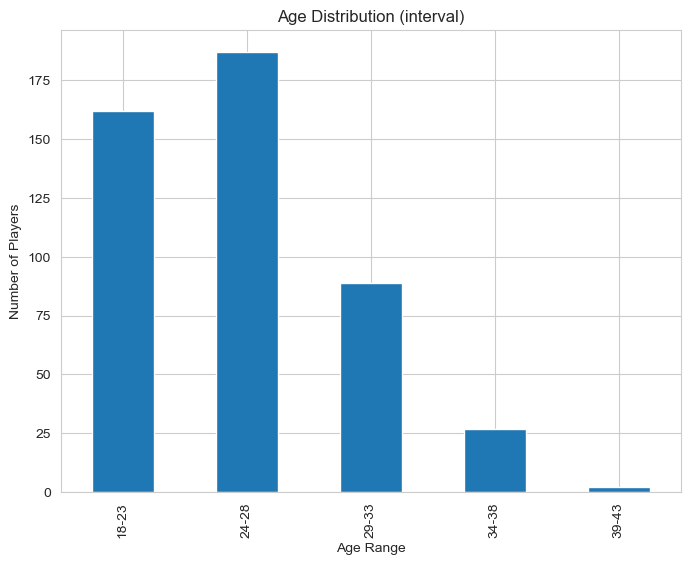

In [43]:
plt.figure(figsize=(8, 6))

age_distribution.plot(kind='bar')
plt.title('Age Distribution (interval)')
plt.xlabel('Age Range')
plt.ylabel('Number of Players')
plt.show()

The graph shows the age distribution of NBA players divided into intervals. The majority of players are in the age categories of 24-28 years and 18-23 years, confirming that most professional NBA players are at their physical peak during this period.

C:\Users\danie\AppData\Local\Temp\ipykernel_59560\4222072432.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Position',y='Salary',data=df,palette='viridis')


<Axes: xlabel='Position', ylabel='Salary'>

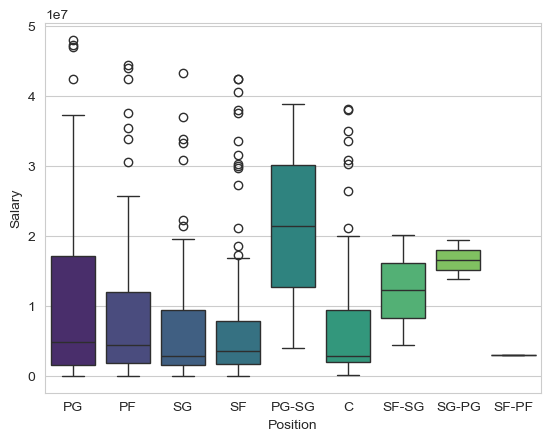

In [45]:
sns.boxplot(x='Position',y='Salary',data=df,palette='viridis')

Conclusion: Based on the boxplot, we can see that some positions, such as PG, tend to have a wider range of salaries. The salaries for PG-SG positions appear higher because we have fewer data points from them

What next: We will use inferential analysis methods to verify whether there is a statistically significant difference between them.

# Analysis 1
## Inferential analysis - tests on mean values

In [ ]:
We want to verify whether there is a statistically significant difference between the ages of Guards ( G ) and Forwards ( F ) Therefore, we formulate the null hypothesis.
H0: There is no statistically significant difference between the ages of Guards ( G ) and Forwards ( F )

We will use a two-sample t-test to verify this, since the ages of Guards and Forwards are independent. However, before applying the t-test, we will verify the equality of variances using Levene's test. This analysis will allow us to determine whether the age structure between these two groups of players shows statistically significant differences.

In [18]:
guards = data_cleaned[data_cleaned['Position'].str.contains('G')]['Age'].dropna()
forwards = data_cleaned[data_cleaned['Position'].str.contains('F')]['Age'].dropna()

levene_stat, levene_p = levene(guards, forwards)
t_stat, t_p = ttest_ind(guards, forwards, equal_var=True)

{"Levene's Test": {"Statistic": levene_stat, "p-value": levene_p}, "t-Test": {"Statistic": t_stat, "p-value": t_p}}

{"Levene's Test": {'Statistic': 0.01799705078116791,
  'p-value': 0.893353298456712},
 't-Test': {'Statistic': -1.4167319866640027, 'p-value': 0.1573892765075624}}

In [ ]:
Based on the results, we reject H0.

In [ ]:
Conclusion: The ages of Guards and Forwards are not statistically significantly different according to these analyses, and their variances are similar.

# Analysis 2
## Inferential Analysis - Correlation Analysis

Objective of the analysis: The dataset about NBA players contains (among other things) information about the players' annual salaries (Salary) and the average number of points per game (PTS) and the number of games played (GP).

The aim of the following analysis will be to determine whether there is a significant relationship between these parameters and to determine to what extent the player's performance (represented by the number of points) and the number of games played affect his financial evaluation.

We will therefore determine the level of the correlation coefficient between the pairs:

* Salary X PTS
* Salary X GP

Formulation of null hypotheses:

H0 (A): There is no statistically significant relationship between the variables Salary and PTS.

H0 (B): There is no statistically significant relationship between the variables Salary and GP.

Since we have a large number of data, we will use parametric methods of correlation analysis to verify this relationship.

In [100]:
df[["Salary","PTS"]].corr()

,Salary,PTS
Salary,1.000000,0.727597
PTS,0.727597,1.000000


In [ ]:
We see that there is a high correlation between the number of points and salary. The correlation coefficient is as high as 0.73.

We will also check the p value for certainty.

In [ ]:
stats.pearsonr(df["Salary"],
               df["PTS"])

PearsonRResult(statistic=0.7275966928493116, pvalue=3.9581622553381053e-78)

Conclusion: Based on the results, we reject the hypothesis H0 (A). This means that there is a statistically significant relationship between the number of points and salary.

We then verify H0 (B)

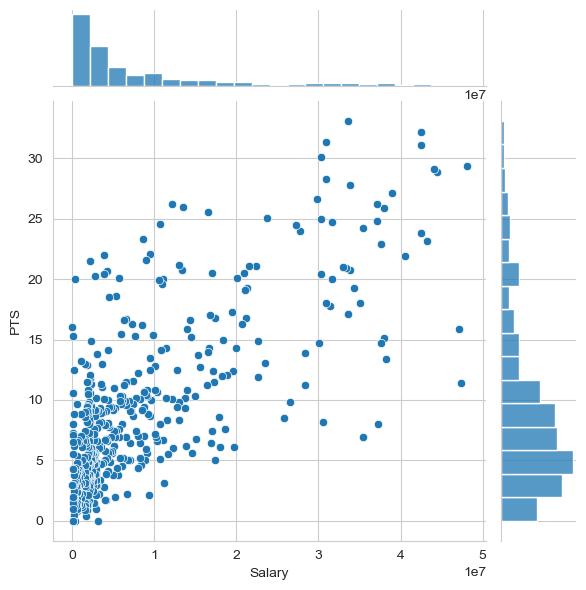

In [104]:
sns.jointplot(data=df, x="Salary", y="PTS")

In [55]:
df[["Salary","GP"]].corr()

,Salary,GP
Salary,1.000000,0.341707
GP,0.341707,1.000000


In [ ]:
Based on the correlation matrix, the correlation coefficient between player salaries and number of games played (GP) is 0.34
which indicates a slightly positive relationship. This means that players with higher salaries tend to play more games, but the relationship is not strong.

We will also verify this using the p value.

In [ ]:
stats.pearsonr(df["Salary"],
               df["GP"])

PearsonRResult(statistic=0.34170652737819396, pvalue=3.0936906724153366e-14)

The p-value is very low p < 0.001, which means that the correlation is statistically significant.
Based on these results, we reject the null hypothesis H0 (B)

Conclusion: The results suggest that a player's performance, as measured by the number of points per game, has a greater impact on his salary than the number of games played. That is, quality players who score regularly are financially rewarded more.

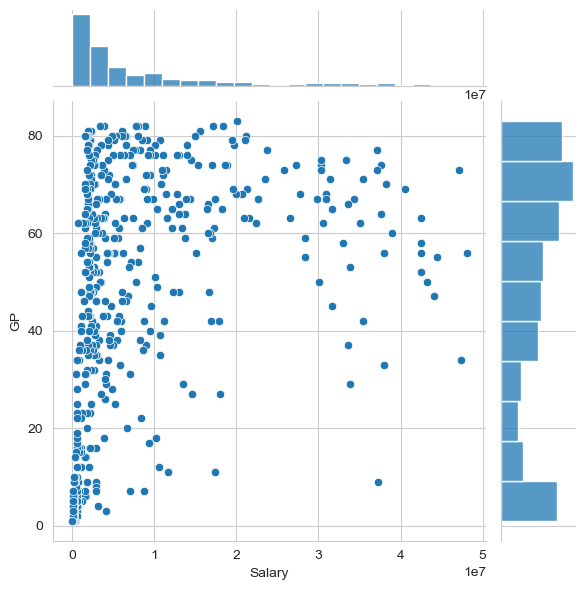

In [59]:
sns.jointplot(data=df, x="Salary", y="GP")

# Analysis 4
## Contingency Analysis

In [ ]:
The aim of this analysis is to examine whether there is a relationship between position and age
We choose the null hypothesis:
H0: Age does not affect the player's position, the variables are independent

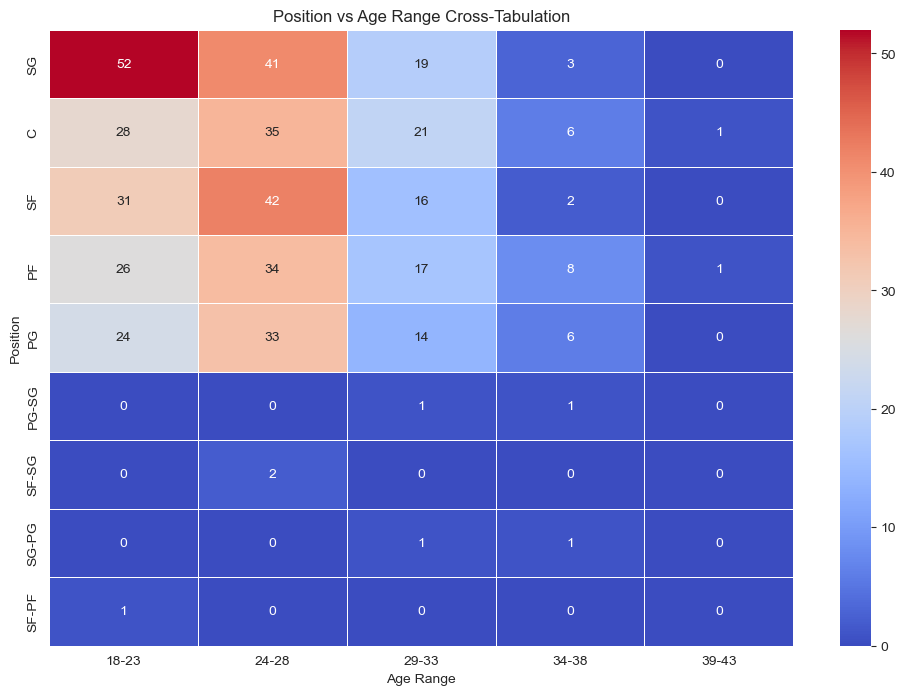

In [179]:
position_age_ct = pd.crosstab(df['Position'], age_bins)
position_age_ct['Total'] = position_age_ct.sum(axis=1)
position_age_ct_sorted = position_age_ct.sort_values('Total', ascending=False).drop(columns=['Total'])
plt.figure(figsize=(12, 8))
sns.heatmap(position_age_ct_sorted, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Position vs Age Range Cross-Tabulation')
plt.xlabel('Age Range')
plt.ylabel('Position')
plt.show()

In [77]:
chi2, p, dof, ex = chi2_contingency(position_age_ct)

print(f"Chi2: {chi2}")
print(f"p-hodnota: {p}")

Chi2: 40.97124788737964
p-hodnota: 0.13292728895148495


Based on the p-value (0.133), there is no reason to reject the null hypothesis. This indicates that there is no statistically significant relationship between a player's position and their age category.

# Conclusion

The analysis of NBA players in the 2022-2023 season involved various statistical approaches to understand the relationships between player salaries, their performance, and demographic indicators. Key insights from the interference and contingency analyses are as follows:

Strong correlation between performance and salary: There is a significant positive correlation between average points per game and salary. This relationship highlights the importance of a player’s performance to their financial evaluation.
Weaker correlation between number of games and salary: Number of games played has a weaker positive correlation with salary. This suggests that regular participation in games is important, but not decisive for financial rewards.
Player positions: The visualizations showed that some positions have a wider salary distribution, which may reflect different importance and specialization within the team.
This research highlights the importance of peak performance in the financial valuation of players and provides a solid foundation for further analysis in the field of sports economics.